## Введение. 
В нашем распоряжении данные металлургического комбината, содержащие информацию о производстве стали. На основании этих данных необходимо составить модель машинного обучения, пркедсказывающую итоговую температуру смеси перед разливкой на слябы.
Это позволит заводу оптимизировать затраты на электроэнергию, увеличить количество циклов работы ковша, а также позволит проранжировать влияние факторов процесса обработки.

### Струкутра данных: 
1. Данные о затраченной энергии.
2. Время использования добавок первого типа. 
3. Количество использованных добавок первого типа. 
4. Количество использованного газа на каждую партию стали. 
5. Изменения температуры для каждой партии стали.
6. Время использования добавок второго типа. 
7. Количество использованных добавок второго типа. 

### Очередность работ: 
1. Предобработка данных
2. Создание единой таблицы признаков.
3. Выбор и обучение модели. 
4. Тестирование выбранной модели.

## Предобработка данных

In [1]:
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from scipy.stats import kstest
from scipy.stats import shapiro
from sklearn.model_selection import GridSearchCV

In [2]:
try:
    data_arc = pd.read_csv('final_steel/data_arc.csv')
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
    data_bulk = pd.read_csv('final_steel/data_bulk.csv')
    data_gas = pd.read_csv('final_steel/data_gas.csv')
    data_temp = pd.read_csv('final_steel/data_temp.csv')
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')
    data_wire = pd.read_csv('final_steel/data_wire.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
(data_arc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В нашем распоряжении 14 876 строк данных, каждая из которых содержит информацию об итерации нагрева для партии. 
В каждой из приведенных колонок содержится одинаковое количество записей, заполнение пропусков не требуется.

В рамках предобработки выполним следующие шаги: 
1. Переименуем колонки. 
2. Изменим тип данных на datetime в колонках начала и конца нагрева. 
3. Вычислим значение работы для каждой итерации, для этого: 
    
    
    3.1 Найдем разницу между началом и концом итерации нагревания в секундах. 
    3.2 Умножим значение активной мощности на время нагрева. 
4. Методом describe изучим данные.
5. Так как единицей измерения и предсказания модели является целый ковш, переформатируем таблицу в сводную, где сохраним суммарное количество работы на ковш, а также количество выработанной реактивной мощности. 

AxesSubplot(0.125,0.125;0.775x0.755)


key  active_power  reactive_power  total_time_heating  \
count  14876.000000  14876.000000    14876.000000        14876.000000   
mean    1615.220422      0.670441        0.452592          171.670946   
std      934.571502      0.408159        5.878702           98.186803   
min        1.000000      0.030002     -715.504924           11.000000   
25%      806.000000      0.395297        0.290991          107.000000   
50%     1617.000000      0.555517        0.415962          147.000000   
75%     2429.000000      0.857034        0.637371          214.000000   
max     3241.000000      3.731596        2.676388          907.000000   

               work  
count  14876.000000  
mean     154.131709  
std      206.346573  
min        0.330021  
25%       42.875353  
50%       80.932346  
75%      182.017739  
max     3384.557674

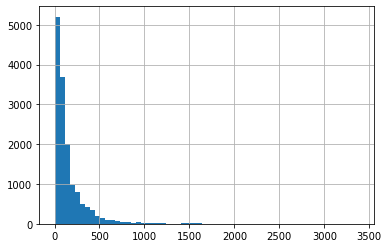

In [4]:
data_arc.columns = ['key', 'arc_heating_start', 'arc_heating_end', 'active_power', 'reactive_power']
data_arc['arc_heating_start'] = pd.to_datetime(data_arc['arc_heating_start'])
data_arc['arc_heating_end'] = pd.to_datetime(data_arc['arc_heating_end'])
data_arc['total_time_heating'] = ((data_arc['arc_heating_end']) - (data_arc['arc_heating_start'])).dt.seconds
data_arc['work'] = data_arc['total_time_heating']*data_arc['active_power']
print(data_arc['work'].hist(bins = 60))
data_arc.describe()

Видно, что есть выбросы, при общем нормальном распределнии значений.

Так как: 
1. Эти данные собраны не вручную. 
2. В нашем рапоряжении данные по 3 241 ковшу, что не очень много. 
Оставим выбросы, как есть. 

Переформатируем таблицу в сводную по ковшам. 

In [5]:
print ('Если оставим как есть pvalue составит', shapiro(data_arc['work']))
print ('Если выполним предобработку, pvalue составит', shapiro(np.log(data_arc['work'].values)))

Если оставим как есть pvalue составит ShapiroResult(statistic=0.628873348236084, pvalue=0.0)
Если выполним предобработку, pvalue составит ShapiroResult(statistic=0.9917111992835999, pvalue=2.4524320058990686e-28)


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [6]:
data_arc['work'] = np.log(data_arc['work'].values)

In [7]:
data_arc = pd.pivot_table(data_arc, 
               index = 'key', 
               values = ['work', 'reactive_power'], 
               aggfunc='sum').reset_index()

display(data_arc.corr())
display(data_arc.describe())
data_arc.tail()

key  reactive_power      work
key             1.000000       -0.010812 -0.041870
reactive_power -0.010812        1.000000  0.087127
work           -0.041870        0.087127  1.000000

key  reactive_power         work
count  3214.000000     3214.000000  3214.000000
mean   1623.061294        2.094821    20.448048
std     934.739859       12.689508     7.234556
min       1.000000     -714.591636     2.362255
25%     817.250000        1.599018    15.681268
50%    1623.500000        2.229869    20.128687
75%    2431.750000        2.899141    24.599679
max    3241.000000       12.587990    76.827026

key  reactive_power       work
3209  3237        2.828459  24.308083
3210  3238        1.681182  14.120289
3211  3239        3.111617  34.299791
3212  3240        2.483267  22.586666
3213  3241        1.696199  19.880353

In [8]:
indexes_to_drop = data_arc[data_arc['reactive_power']>10].index
data_arc = data_arc.drop(index = indexes_to_drop)
data_arc.corr()

key  reactive_power      work
key             1.000000       -0.010934 -0.043810
reactive_power -0.010934        1.000000  0.085239
work           -0.043810        0.085239  1.000000

Видно, что есть ковши, по которым нет данных по затраченной мощности. 
При дальнейшем объединении таблиц, будем учитывать только те ковши, по которым представлен весь объем необходимой информации. 

Данные в таблице не коррелируют между собой. 

In [9]:
print(data_temp.info())
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

В нашем распоряжении 15 907 строк, каждой из которых соответсвует измерение температуры в ковше. 
Отметим, что значение температуры есть только для 13 006 замеров. Одному ковшу соотвествует несколько замеров. 
Так как нам важно уметь предсказать температу итоговой смеси, целевым признаком является последний замер температуры. Также, важным признаком может стать температура смеси, с которой начинается процесс обработки смеси. Этому значению соответсвует первый замер в таблице.

В рамках предобработки выполним следующие шаги:
1. Переименуем колонки
2. Изменим тип данных в колонке "Время замера" на datetime
3. Для каждого ковша найдем температуру, соответствующую первому замеру и температуру, соответствующую последнему замеру. Сохраним эти данные в сводной таблице. 
4. Изучим полученные данные методом describe().
5. При наличии ковшей с незаполненными данными, выполним работу над пропусками. 

In [10]:
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

AxesSubplot(0.125,0.125;0.775x0.755)


key  target_temp   first_temp
count  2477.000000  2477.000000  2477.000000
mean   1249.968510  1595.334275  1588.405733
std     720.073717    16.019339    29.232904
min       1.000000  1541.000000  1191.000000
25%     628.000000  1587.000000  1572.000000
50%    1251.000000  1593.000000  1588.000000
75%    1872.000000  1599.000000  1605.000000
max    2499.000000  1700.000000  1679.000000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2477 non-null   int64  
 1   target_temp  2477 non-null   float64
 2   first_temp   2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB
None


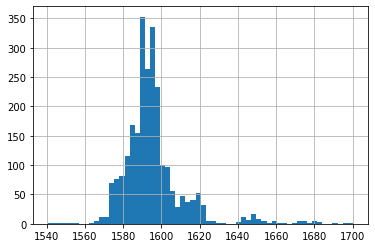

In [11]:
# Временная сводная таблица, содержащая данные о целевой температуре
max_temps = (pd.pivot_table(data_temp, index = 'key', values = 'measurement_time', aggfunc='max')
 .reset_index()
 .merge(data_temp, how = 'left', on = ['key', 'measurement_time'])
)
max_temps.columns = ['key', 'max_time', 'target_temp']

# Временная сводная таблица, содержащая данные о первоначальной температуре
min_temps = (pd.pivot_table(data_temp, index = 'key', values = 'measurement_time', aggfunc='min')
 .reset_index()
 .merge(data_temp, how = 'left', on = ['key', 'measurement_time'])
)
min_temps.columns = ['key', 'min_time', 'first_temp']

# Мердж временных таблиц
temps_agg = max_temps.merge(min_temps, how = 'inner', on = 'key')
temps_agg = temps_agg.drop(columns = ['max_time', 'min_time'])
temps_agg = temps_agg.dropna()
print(temps_agg['target_temp'].hist(bins = 60))
display(temps_agg.describe())
print(temps_agg.info())

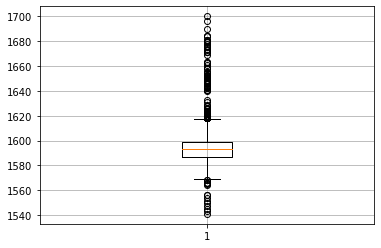

In [12]:
plt.plot()
plt.boxplot(temps_agg['target_temp'])
plt.grid()
plt.show()

In [13]:
shapiro(temps_agg['target_temp']).pvalue

0.0

Данные распределены нормально. 

Видно, что по последним партиям отсутсвует замер температуры финальной смеси. Изучим данные подробнее. Возможно, стоит взять предыдущий замер. 

In [14]:
count_temperatures=[]
for i in temps_agg[temps_agg['target_temp'].isna() == True]['key']:
    count_temperatures.append(data_temp[data_temp['key']==i]['temperature'].count())
print ('Количество партий, где нет финального замера температуры, но есть более одного замера:',sum([count_temperatures[x]>1 for x in range(len(count_temperatures))]))
print ('Общее количество партий, без целевого признака:', len(count_temperatures))

Количество партий, где нет финального замера температуры, но есть более одного замера: 0
Общее количество партий, без целевого признака: 0


Исследуем таблицу data_bulk_time

In [15]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

In [16]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Видно, что таблица представляет данные о дате и времени добавлении веществ в основную массу ковша. 
Очередность добавления не предствляет интереса для модели, прогнозирующей итоговую температуру. Поэтому использовать временные ряды мы не будем. Оставим таблицу без предобработки. Таблица data_wire_time по аналогичным причинам использована не будет.

Рассмотрим таблицу data_bulk. 

In [17]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Таблица показывает содержание добавок в каждой партии стали. 
Пропущенные значение означают отсутствие данной добавки в данной партии. 

Видно, что значительное количество раз добавлялись в партии добавки номер 14, 15, 12. Эти добавки оставим самостоятельными признаками. По остальным добавкам найдем сумму для каждой партии и сохраним в признак 'other_bulks'.

Порядок предобработки: 
1. Переименуем колонки таблицы 
2. Рассмотрим коэффициенты корреляции между добавками. 
3. Заполним пропуски нулями. 
4. Изучим данные методом describe() 

In [18]:
data_bulk.columns = [x.lower() for x in data_bulk.columns]
data_bulk.columns = [x.replace(' ', '_') for x in data_bulk.columns]


In [19]:
columns_for_sum = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_13',]
data_bulk['other_bulks'] = data_bulk[columns_for_sum].sum(axis=1)
data_bulk = data_bulk[['key', 'bulk_12', 'bulk_14', 'bulk_15', 'other_bulks']]
data_bulk = data_bulk.fillna(0)
data_bulk.describe()

key      bulk_12      bulk_14      bulk_15  other_bulks
count  3129.000000  3129.000000  3129.000000  3129.000000  3129.000000
mean   1624.383509   203.948226   152.706616   115.319271   123.529243
std     933.337642   151.419639    81.091421    84.488698   115.210812
min       1.000000     0.000000     0.000000     0.000000     0.000000
25%     816.000000   105.000000   104.000000     0.000000    54.000000
50%    1622.000000   206.000000   148.000000   106.000000   104.000000
75%    2431.000000   263.000000   202.000000   204.000000   163.000000
max    3241.000000  1849.000000   636.000000   405.000000  1276.000000

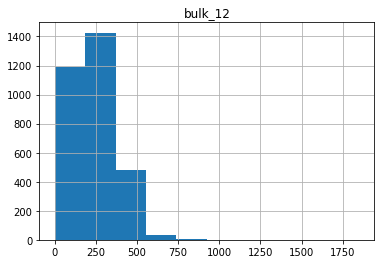

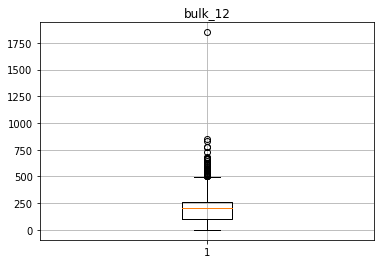

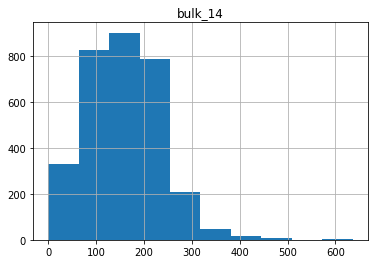

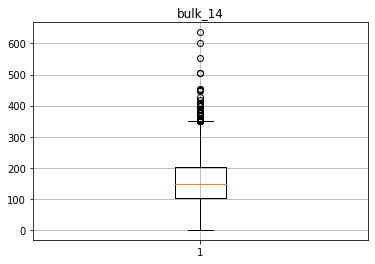

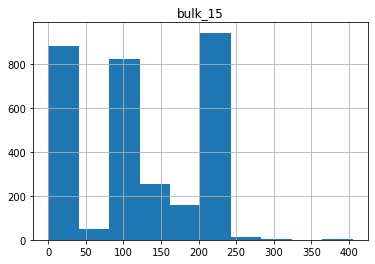

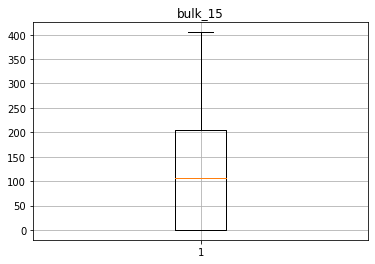

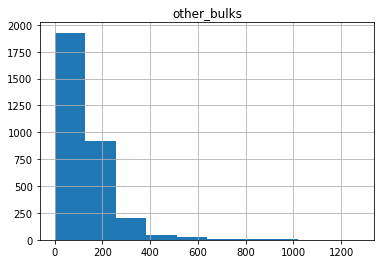

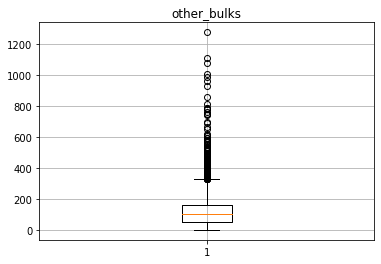

In [20]:
for i in data_bulk.columns[1:]:
    plt.figure()
    plt.grid()
    plt.hist(data_bulk[i])
    plt.title(i)
    plt.show()
    plt.boxplot(data_bulk[i])
    plt.grid()
    plt.title(i)
    plt.show()

In [21]:
for i in data_bulk.columns[1:]: 
    print (i, shapiro(data_bulk[i]))

bulk_12 ShapiroResult(statistic=0.9165238738059998, pvalue=1.661989864914563e-38)
bulk_14 ShapiroResult(statistic=0.9527525305747986, pvalue=1.1423459743663874e-30)
bulk_15 ShapiroResult(statistic=0.8556951880455017, pvalue=0.0)
other_bulks ShapiroResult(statistic=0.7979310750961304, pvalue=0.0)


Дальнейшей обработки не требуется, данные можно использовать для обучения модели. 

Изучим данные об использовании газа.

In [22]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице представлены данные по количеству использованного газа для каждой партии стали. 
Количество значений в каждой колонке одинаковое, работа с пропусками не требуется. 

Порядок предобработки: 
1. Переименуем колонки.
2. Методом describe() изучим представленные данные.

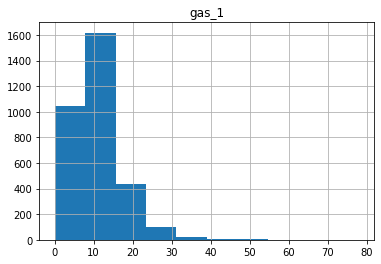

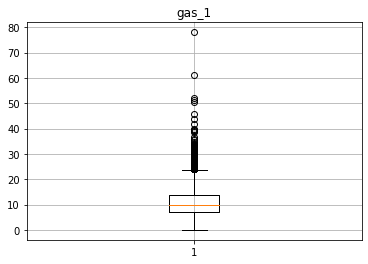

key        gas_1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

In [23]:
data_gas.columns = ['key', 'gas_1']
plt.figure()
plt.grid()
plt.hist(data_gas['gas_1'])
plt.title('gas_1')
plt.show()
plt.boxplot(data_gas['gas_1'])
plt.grid()
plt.title('gas_1')
plt.show()
data_gas.describe()

In [24]:
shapiro(data_gas['gas_1'])


ShapiroResult(statistic=0.8867924809455872, pvalue=1.14906474074635e-43)

In [25]:
shapiro(np.sqrt(data_gas['gas_1'].values))

ShapiroResult(statistic=0.9831494092941284, pvalue=3.371364062518927e-19)

In [26]:
data_gas['gas_1'] = np.sqrt(data_gas['gas_1'].values)

Данные рапределены нормально, есть небольшое количество выбросов. Учитывая, что данные собраны не в ручную, оставим значения без изменений.

Изучим таблицу data_wire. 

In [27]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Таблица, аналогичная таблице data_bulk, только по другим добавкам. Видно, что только первая и вторая добавки встречаются достаточно часто, чтобы стать признаком в модели. Составим новую, сводную таблицу, с суммарными значениями всех добавок для каждой партии стали. 
В рамках предобработки: 
1. Переименуем колонки таблицы.
2. Найдем построчно сумму всех добавок. 
3. Изучим данные методом describe()

In [28]:
data_wire.columns = [x.lower() for x in data_wire.columns]
data_wire.columns = [x.replace(' ', '_') for x in data_wire.columns]

In [29]:
columns = data_wire.columns[1:]
data_wire['total_wires'] = data_wire[columns].sum(axis=1)
data_wire = data_wire[['key', 'total_wires']]

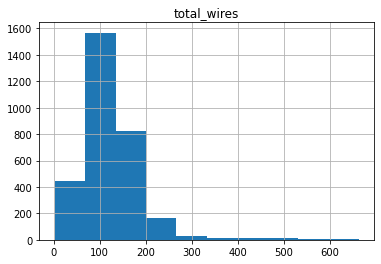

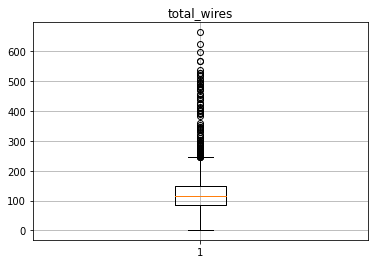

key  total_wires
count  3081.000000  3081.000000
mean   1623.426485   123.723326
std     932.996726    66.082966
min       1.000000     1.918800
25%     823.000000    86.112000
50%    1619.000000   114.179523
75%    2434.000000   150.181198
max    3241.000000   663.851766

In [30]:
plt.figure()
plt.grid()
plt.hist(data_wire['total_wires'])
plt.title('total_wires')
plt.show()
plt.boxplot(data_wire['total_wires'])
plt.grid()
plt.title('total_wires')
plt.show()
data_gas.describe()
data_wire.describe()

In [31]:
shapiro(data_wire['total_wires'])

ShapiroResult(statistic=0.8337795734405518, pvalue=0.0)

In [32]:
shapiro(np.sqrt(data_wire['total_wires'].values))

ShapiroResult(statistic=0.9573911428451538, pvalue=3.850190348253931e-29)

In [33]:
data_wire['total_wires'] = np.sqrt(data_wire['total_wires'])

Данные распределены нормально, есть некоторое количество выбросов. Так как эти данные собраны автоматически, это говорит скорее о качестве первоначального сырья, которое может требовать значительного количества добавок, для получения стали необходимого качества. Оставим выбросы без предобработки. 

Также, можно заметить, что по нескольким партиям добавки отсутсвовали в принципе. Решение о том, заполнить ли эти пропуски нулями примем при объединении подготовленных таблиц в одну единую, на основании полноты значений по другим признакам. 

## План работ: 
1. Создать единую таблицу, содержащую данные из всех таблиц, подготовленных в рамках первого этапа. При объединении будем использовать 'inner join', чтобы получить партии с максимальным количеством заполненных признаков. 
    1а. Если данных в итоговой таблице окажется мало, то необходимо будет или вернуться к предыдущему этапу и поработать с пропусками на этапе создания составляющих итоговой таблицы. 
    1б. Использовать иные типы джоинов, чтобы в итоговую таблицу попало как можно больше партий с как можно большим количеством заполненных признаков. 
2. Разделить признаки на целевой - 'target_temp' и обучающие - все остальные. 
3. Для обучающих признаков провести графический анализ, а также рассмотреть коэффициенты корреляции. 
    3а. Если по одному или нескольким признакам коэффициент корреляции будет близок к единице - такие признаки необходимо будет удалить из таблицы признаков.
4. Разделить данные на выборки - обучающую и валидационную методом train_test_split(). Пропорция 25%.
5. Выполнить нормализацию признаков методом StandardScaler()
    5а. Методом fit_transform() преобразовать данные обучающей выборки.
    5б. Методом transform() преобразовать данные валидационной выборки. Таким образом признаки валидационной выборки не окажут влияния на тестовые данные. 
6. Обучить на тестовых данных модель линейной регрессии. Далее, методом кросс-валидации посчитать метрику mae. 7. Обучить на тестовых данных модель catBoost. Далее, методом кросс-валидации посчитать матрику mae. 
8. Обучить на тестовых данных модель случайного дерева. Далее методом кросс-валидации посчитать метрику mae. 
9. На основании метрик выбрать наиболее подходящую модель для задачи (Ставлю на catBoost). 
10. Для выбранной модели выполнить перебор гиперпараметров с целью оптимизации метрики. Метрику, также как и в предыдущих пунктах будем оценивать с помощью кросс-валидации. 
11. Моделью с подобранными гиперпараметрами предсказать значения целевого признака на валидационной выборке. 
12. Посчитать метрику MAE для предсказанных значений. 
13. Если метрика MAE меньше или равна 6.8 градусов, то вывести получившиеся веса признаков. 
14. Написать вывод не хуже, чем в Стэнфорде. 

## Создание единой таблицы 

Необходимо объединить данные из пяти таблиц: 
1. data_arc
2. temps_agg
3. data_bulk
4. data_gas
5. data_wire

В каждой из них есть колонка 'key', на основании которой будем выполнять объединение. 

In [34]:
agg_data = (data_arc.merge(temps_agg, on='key', how = 'inner')
            .merge(data_bulk, on='key', how = 'inner')
            .merge(data_gas, on='key', how = 'inner')
            .merge(data_wire, on='key', how = 'inner')
           )
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 2326
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2327 non-null   int64  
 1   reactive_power  2327 non-null   float64
 2   work            2327 non-null   float64
 3   target_temp     2327 non-null   float64
 4   first_temp      2327 non-null   float64
 5   bulk_12         2327 non-null   float64
 6   bulk_14         2327 non-null   float64
 7   bulk_15         2327 non-null   float64
 8   other_bulks     2327 non-null   float64
 9   gas_1           2327 non-null   float64
 10  total_wires     2327 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 218.2 KB


In [35]:
agg_data

key  reactive_power       work  target_temp  first_temp  bulk_12  \
0        1        3.183241  26.298042       1613.0      1571.0    206.0   
1        2        1.998112  19.458993       1602.0      1581.0    206.0   
2        3        1.599076  19.564914       1599.0      1596.0    205.0   
3        4        2.060298  19.449127       1625.0      1601.0    207.0   
4        5        2.252643  19.135379       1602.0      1576.0    203.0   
...    ...             ...        ...          ...         ...      ...   
2322  2495        2.360777  19.511164       1591.0      1570.0    256.0   
2323  2496        2.810185  27.538157       1591.0      1554.0    256.0   
2324  2497        1.851269  14.759462       1589.0      1571.0    230.0   
2325  2498        2.355428  21.512078       1594.0      1591.0    206.0   
2326  2499        2.777865  20.509724       1603.0      1569.0    233.0   

      bulk_14  bulk_15  other_bulks     gas_1  total_wires  
0       150.0    154.0         43.0  5.454355     7.749839  
1       149.0    154.0         73.0  3.543383     9.800628  
2       152.0    153.0         34.0  5.343668     9.547783  
3       153.0    154.0         81.0  4.340647     9.437347  
4       151.0    152.0         78.0  2.326734     9.917298  
...       ...      ...          ...       ...          ...  
2322    129.0    223.0        111.0  2.669407     9.441974  
2323    129.0    226.0        185.0  3.067999    10.685482  
2324    124.0    226.0         85.0  2.504336    10.155527  
2325    129.0    207.0        191.0  3.866996    10.867875  
2326    126.0    227.0         47.0  3.366920    12.655680  

[2327 rows x 11 columns]

По итогам мерджинга способом 'inner' в нашем распоряжении оказалось данные по 3022 ковшам, что составляет 94% изначального фрейма. Продолжим работу с аггрегированной таблицей.  

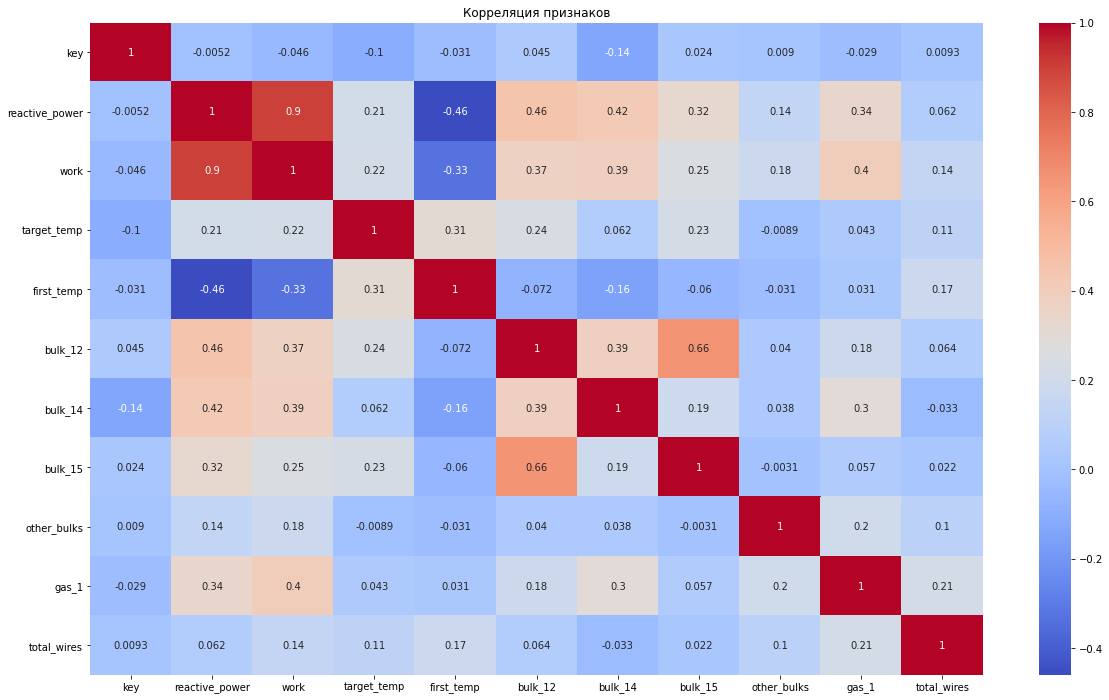

In [37]:
import seaborn as sns
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(agg_data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [38]:
agg_data = agg_data.drop(columns = 'reactive_power')

Явной корреляции между признаками нет. Оставляем набор признаков таким, как есть. 

Разделим выборку на признаки и целевой признак.

In [39]:
features = agg_data.drop(columns = ['target_temp', 'key'])
target = agg_data['target_temp']

print (features.shape)
print (target.shape)

(2327, 8)
(2327,)


In [40]:
features

work  first_temp  bulk_12  bulk_14  bulk_15  other_bulks     gas_1  \
0     26.298042      1571.0    206.0    150.0    154.0         43.0  5.454355   
1     19.458993      1581.0    206.0    149.0    154.0         73.0  3.543383   
2     19.564914      1596.0    205.0    152.0    153.0         34.0  5.343668   
3     19.449127      1601.0    207.0    153.0    154.0         81.0  4.340647   
4     19.135379      1576.0    203.0    151.0    152.0         78.0  2.326734   
...         ...         ...      ...      ...      ...          ...       ...   
2322  19.511164      1570.0    256.0    129.0    223.0        111.0  2.669407   
2323  27.538157      1554.0    256.0    129.0    226.0        185.0  3.067999   
2324  14.759462      1571.0    230.0    124.0    226.0         85.0  2.504336   
2325  21.512078      1591.0    206.0    129.0    207.0        191.0  3.866996   
2326  20.509724      1569.0    233.0    126.0    227.0         47.0  3.366920   

      total_wires  
0        7.749839  
1        9.800628  
2        9.547783  
3        9.437347  
4        9.917298  
...           ...  
2322     9.441974  
2323    10.685482  
2324    10.155527  
2325    10.867875  
2326    12.655680  

[2327 rows x 8 columns]

Разделим получившиеся датафреймы на обучающую и валидационные выборки. 

In [41]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target
                                                                              ,random_state = 281122
                                                                             ,test_size=0.25)
print (features_train.shape)
print (features_valid.shape)
print (target_train.shape)
print (target_valid.shape)

(1745, 8)
(582, 8)
(1745,)
(582,)


In [42]:
features_train

work  first_temp  bulk_12  bulk_14  bulk_15  other_bulks     gas_1  \
1556  23.593815      1562.0    183.0    182.0    125.0        147.0  3.405259   
1480  12.998030      1573.0      0.0    141.0      0.0          0.0  2.105178   
2153  27.527648      1589.0      0.0    246.0    104.0         16.0  4.137795   
832   17.811901      1600.0      0.0      0.0      0.0         55.0  4.776327   
522   16.996426      1599.0    204.0    174.0    201.0        290.0  3.164355   
...         ...         ...      ...      ...      ...          ...       ...   
124   13.836706      1617.0    105.0    152.0      0.0         53.0  2.329972   
697   23.445872      1603.0    207.0    105.0    203.0         83.0  3.286039   
1524   8.124177      1610.0      0.0      0.0      0.0         44.0  3.291613   
2271  32.387691      1603.0    316.0    184.0    213.0        136.0  3.618324   
233   29.104421      1597.0    458.0    258.0    151.0         68.0  5.800766   

      total_wires  
1556    14.332363  
1480     9.951322  
2153    10.055804  
832     11.797593  
522     10.457342  
...           ...  
124      9.131546  
697     12.056566  
1524    12.150397  
2271    11.149586  
233      8.842353  

[1745 rows x 8 columns]

Выполним скалирование признаков. 

In [43]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)

## Обучение и выбор модели.

In [44]:
model = LinearRegression()
scores = cross_val_score(model, features_train, target_train, n_jobs = 5, scoring = 'neg_mean_absolute_error', cv= 5)
lr_best_result = np.mean(np.abs(scores))
results = []
results.append(lr_best_result)

In [46]:
lr_best_result

7.119246491042245

In [47]:
model = RandomForestRegressor(random_state=281122)
params = [{'n_estimators':[200,300,400, 500], 'max_depth':[7,8,9]}]
gs = GridSearchCV(model, param_grid= params, scoring='neg_mean_absolute_error', cv = 5)
gs.fit(features_train, target_train)
rf_best_score = (gs.best_score_)
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [48]:
model = CatBoostRegressor(random_seed = 281122, loss_function='MAE')
params = [{'learning_rate':[0.1,0.01, 0.085], 'max_depth': [6,7,8], 'score_function':['Cosine', 'L2', 'NewtonCosine', 'NewtonL2']}]
gs = GridSearchCV(model, param_grid = params, scoring = 'neg_mean_absolute_error', cv = 5)
gs.fit(features_train, target_train)

0:	learn: 7.8618185	total: 60ms	remaining: 60s
1:	learn: 7.7291896	total: 61.4ms	remaining: 30.7s
2:	learn: 7.6074123	total: 62.4ms	remaining: 20.7s
3:	learn: 7.4897570	total: 63.2ms	remaining: 15.7s
4:	learn: 7.3486867	total: 64ms	remaining: 12.7s
5:	learn: 7.2652891	total: 64.9ms	remaining: 10.8s
6:	learn: 7.1655327	total: 65.8ms	remaining: 9.33s
7:	learn: 7.0945503	total: 66.5ms	remaining: 8.25s
8:	learn: 7.0276385	total: 67.3ms	remaining: 7.41s
9:	learn: 6.9659868	total: 68.4ms	remaining: 6.78s
10:	learn: 6.9063315	total: 69.6ms	remaining: 6.26s
11:	learn: 6.8510050	total: 70.6ms	remaining: 5.81s
12:	learn: 6.7763957	total: 71.9ms	remaining: 5.46s
13:	learn: 6.7227329	total: 73.1ms	remaining: 5.15s
14:	learn: 6.6744429	total: 74.4ms	remaining: 4.88s
15:	learn: 6.6216165	total: 75.4ms	remaining: 4.63s
16:	learn: 6.5902780	total: 76.8ms	remaining: 4.44s
17:	learn: 6.5523504	total: 77.6ms	remaining: 4.23s
18:	learn: 6.5052250	total: 78.4ms	remaining: 4.05s
19:	learn: 6.4541233	total: 

/Users/ivanpeskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ivanpeskov/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ivanpeskov/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/Users/ivanpeskov/opt/anaconda3/lib/python3.9/site-pac

102:	learn: 6.9708800	total: 102ms	remaining: 888ms
103:	learn: 6.9630758	total: 103ms	remaining: 889ms
104:	learn: 6.9561446	total: 104ms	remaining: 888ms
105:	learn: 6.9511282	total: 105ms	remaining: 888ms
106:	learn: 6.9456340	total: 106ms	remaining: 887ms
107:	learn: 6.9402751	total: 107ms	remaining: 887ms
108:	learn: 6.9341973	total: 109ms	remaining: 887ms
109:	learn: 6.9293269	total: 110ms	remaining: 886ms
110:	learn: 6.9240275	total: 111ms	remaining: 885ms
111:	learn: 6.9176540	total: 111ms	remaining: 883ms
112:	learn: 6.9134444	total: 112ms	remaining: 883ms
113:	learn: 6.9063648	total: 113ms	remaining: 882ms
114:	learn: 6.8998518	total: 115ms	remaining: 881ms
115:	learn: 6.8935705	total: 115ms	remaining: 880ms
116:	learn: 6.8892541	total: 117ms	remaining: 880ms
117:	learn: 6.8842555	total: 118ms	remaining: 879ms
118:	learn: 6.8767337	total: 119ms	remaining: 878ms
119:	learn: 6.8711730	total: 120ms	remaining: 878ms
120:	learn: 6.8669222	total: 121ms	remaining: 879ms
121:	learn: 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7894a09610>,
             param_grid=[{'learning_rate': [0.1, 0.01, 0.085],
                          'max_depth': [6, 7, 8],
                          'score_function': ['Cosine', 'L2', 'NewtonCosine',
                                             'NewtonL2']}],
             scoring='neg_mean_absolute_error')

In [49]:
cat_boost_best_score = gs.best_score_
gs.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'score_function': 'Cosine'}

In [50]:
data = {'regression': lr_best_result, 'random_forest': abs(rf_best_score), 'cat_boost': abs(cat_boost_best_score)}
df_results = pd.DataFrame(data = data, index = [0])
df_results

regression  random_forest  cat_boost
0    7.119246       6.953479   6.775532

### Тестирование лучшей модели

Лучший результат на тестовых данных показывает модель catBoost c параметрами {'learning_rate': 0.01, 'max_depth': 6, 'score_function': 'Cosine'}

Проверим модель на валидационной выборке.

In [51]:
model = CatBoostRegressor(random_seed = 281122, 
                          loss_function='MAE', 
                          learning_rate = 0.01, 
                          max_depth=6, 
                          score_function='Cosine')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
mean_absolute_error(target_valid, predictions)

0:	learn: 7.9949560	total: 955us	remaining: 955ms
1:	learn: 7.9840684	total: 1.95ms	remaining: 973ms
2:	learn: 7.9709212	total: 2.78ms	remaining: 924ms
3:	learn: 7.9556979	total: 3.61ms	remaining: 899ms
4:	learn: 7.9404755	total: 4.44ms	remaining: 884ms
5:	learn: 7.9260685	total: 5.35ms	remaining: 886ms
6:	learn: 7.9100206	total: 6.12ms	remaining: 868ms
7:	learn: 7.8944146	total: 7.08ms	remaining: 878ms
8:	learn: 7.8800482	total: 8.01ms	remaining: 882ms
9:	learn: 7.8664838	total: 9.06ms	remaining: 897ms
10:	learn: 7.8505589	total: 10.2ms	remaining: 914ms
11:	learn: 7.8378055	total: 11.1ms	remaining: 911ms
12:	learn: 7.8218947	total: 12ms	remaining: 911ms
13:	learn: 7.8090909	total: 13.1ms	remaining: 926ms
14:	learn: 7.7958434	total: 14.2ms	remaining: 932ms
15:	learn: 7.7829016	total: 15.3ms	remaining: 940ms
16:	learn: 7.7692561	total: 16.6ms	remaining: 958ms
17:	learn: 7.7565486	total: 17.6ms	remaining: 961ms
18:	learn: 7.7437766	total: 18.7ms	remaining: 964ms
19:	learn: 7.7294881	tota

6.613817738679068

In [52]:
print('точность предсказания на валидационной выборке составляет:',mean_absolute_error(target_valid, predictions))

точность предсказания на валидационной выборке составляет: 6.613817738679068


In [53]:
dicti={}
for i in range(len(features.columns)):
    dicti[features.columns[i]] = [model.feature_importances_[i]]

In [54]:
df_total_importances = pd.DataFrame(data = dicti)
df_total_importances

work  first_temp    bulk_12   bulk_14   bulk_15  other_bulks  \
0  21.078513   22.822897  10.485534  8.880902  7.658558     9.296623   

      gas_1  total_wires  
0  9.431003    10.345969

In [55]:
import seaborn as sns
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

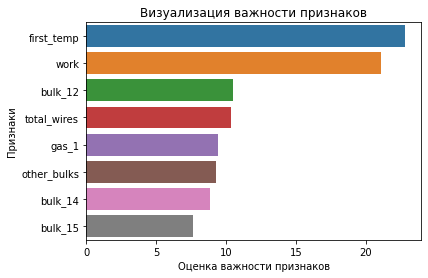

In [56]:
chart_feature_imp(model)

## Отчет

### Решаемая задача. 
Для того, чтобы оптимизировать затраты на энергию и увеличить срок использования промышленного оборудования, завод "Так закаялялась сталь" предоставил оцифроанные данные по обработке стали. 
Наша задача состоит в том, чтобы научиться предсказывать финальную температуру сырья перед отправкой на след. этап, а также показать влияние производственных факторов на итоговую температуру. Это позволит комбинату управлять количеством затрачиваемой энергии, а также оптимизировать наиболее важные части бизнес-процесса.

**Текущий процесс: ** 

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Структура данных:** 

1. Данные о затраченной энергии. В данной таблице содержатся данные обо всех итерациях нагревания всех партий. Для одной партии может быть несколько записей в таблице. По каждой итерации нагревания содержатся данные о времени начала и времени окончания, затраченной активной мощности, затраченной реактивной мощности.

2. Время использования добавок первого типа. В данной таблице одной строке соответсвует одна партия стали. Показывает время добавления каждой из добавок первого типа в ковш.

3. Количество использованных добавок первого типа. Аналогично таблице два таблица содержит по строке для каждой партии. Показывает количество той или иной добавки в партию. Если добавки в партии не было, значение NaN.

4. Количество использованного газа на каждую партию стали. Таблица показывает общее количество использованного газа для каждой партии. 

5. Изменения температуры для каждой партии стали. Для каждой итерации нагревания замеряют температуру наконец процесса нагревания. Таким образом, для каждой партии может быть несколько температур. Также, таблица хранит время измерения температуры. Первый замер - это температура, с которой заготовка пришла на интересующий нас этап. Финальный замер - это целевой признак, который необходимо научиться предсказывать. 

6. Время использования добавок второго типа. В данной таблице одной строке соответсвует одна партия стали. Показывает время добавления каждой из добавок второго типа в ковш.

7. Количество использованных добавок второго типа. Аналогично таблице два таблица содержит по строке для каждой партии. Показывает количество той или иной добавки в партию. Если добавки в партии не было, значение NaN.

## Описание решения

Задача по предсказанию итоговой температуры представляет из себя задачу регрессии. 
Как следствие, не все данные могут быть полезными для того, чтобы составить признаки. Таблицы, хранящие время использования добавок обоих типов не используются при решении данной задачи. 

### Оставшиеся данные необходимо предобработать.

**Общее для всех таблиц:**
1. Колонки переименованы в соответсвии со snake_case и при необходимости переведены на английский язык. 
2. По каждой колонке построена гистограмма и найден коэффициент Шапиро. Про все используемые данные нельзя сказать, что они распределены нормально. 
3. Все колонки содержащие дату и время того или иного действия переведены в формат datetime. 


**Данные о затраченной энергии.**
Нашли значение работы, умножив количество активной энергии на разницу между временем начала и временем конца в секундах. При дальнейшем изучении данных выяснилось, что полученное значение коррелирует со значением реактивной энерегии, поэтому из этой таблицы в качестве признака для модели использовалось только значение работы. Так как данные о работе не распределены нормально, в рамках предобработки все значения были именены в формате x -> log(x). Также, была составлена сводная таблица, аггрегирующая для каждой партии (значение колонки key) суммарное количество затраченной работы. 

**Количество использованных добавок первого типа.**
В этой таблице заполнили нулями пропуски, так как пропуск означает отсутсвие данной добавки в партии.
Также, в качестве признаков оставили только те добавки, которые используются более чем в 66% партий, это добавки 12, 14 и 15. Остальные добавки сохранили в колоне 'other_bulks'.

**Количество использованного газа на каждую партию стали.**
В данной таблице предобработка данных не требовалась. Чтобы повысить коэффициент Шапиро, все значения были возведены в степень (1/2).

**Изменения температуры для каждой партии стали.**
С помощью временных таблиц нашли для каждой партии первый и последний замер температуры. По части партий оказалоь, что финальная температура не замерялась. Такие данные были удалены из таблиц. Остальные данные объединили в общую таблицу, содержащую по одной строке для каждой из оставшихся партий, и для каждой из них температу начальную и температуру окончания. 

**Количество использованных добавок второго типа.**
В этой таблице заполнили нулями пропуски, так как пропуск означает отсутсвие данной добавки в партии.
Из-за редкого использования добавок этого типа, в качетсве признака взяли только сумму всех добавок для каждой партии. Колонка 'total_wires'. 

### Создание единой таблицы признаков. 
Все пять предобработанных таблиц были объеденены методом merge() с типом объединения inner, таким образом мы полчили только те партии стали, где доступно максимальное количество данных.
Вот так выглядит объединенная таблица:

In [57]:
agg_data.head()

key       work  target_temp  first_temp  bulk_12  bulk_14  bulk_15  \
0    1  26.298042       1613.0      1571.0    206.0    150.0    154.0   
1    2  19.458993       1602.0      1581.0    206.0    149.0    154.0   
2    3  19.564914       1599.0      1596.0    205.0    152.0    153.0   
3    4  19.449127       1625.0      1601.0    207.0    153.0    154.0   
4    5  19.135379       1602.0      1576.0    203.0    151.0    152.0   

   other_bulks     gas_1  total_wires  
0         43.0  5.454355     7.749839  
1         73.0  3.543383     9.800628  
2         34.0  5.343668     9.547783  
3         81.0  4.340647     9.437347  
4         78.0  2.326734     9.917298

### Работа с объединенной таблицей. 
Для образованной таблицы была построена тепловая карта по признакам, основанная на коэффициенте корреляции Спирмана. 

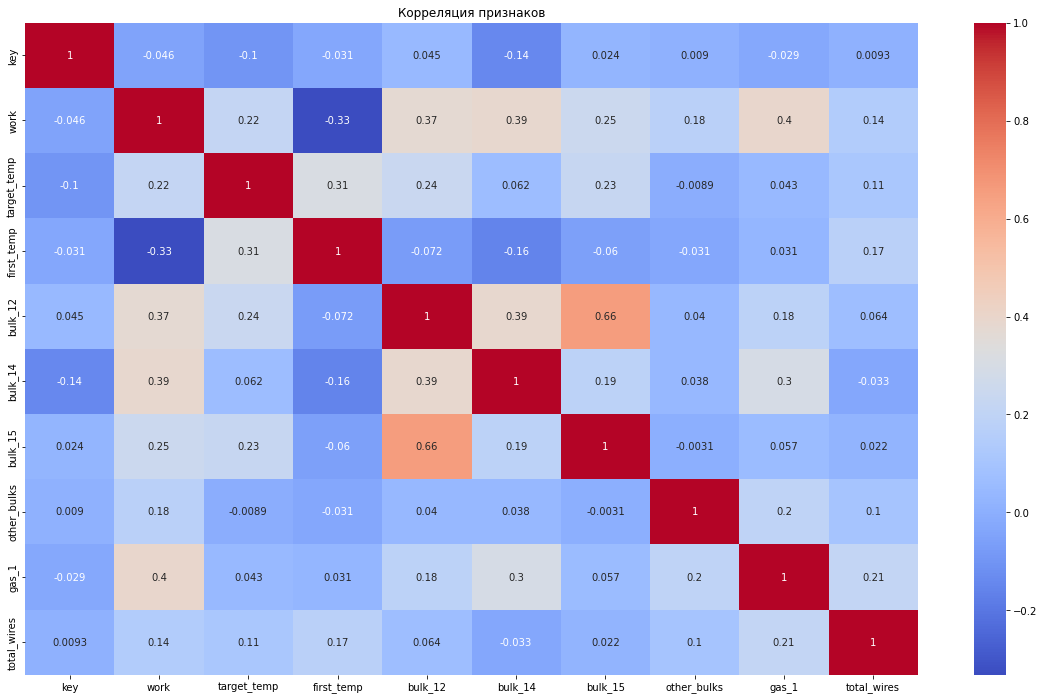

In [59]:
import seaborn as sns
plt.figure(figsize=(20, 12))
plt.title('Корреляция признаков')
sns.heatmap(agg_data.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

Корреляции между признаками нет. 

### Разделение таблицы на обучающие и целевой признаки. 
В качестве обучающих признаков использованы все, кроме key и target_temp. 
Целевой признак - target_temp. 
Далее все таблицы были разделены на тестовую и тренировочную выборки в процпорции 0.25 
Также, все обучающие признаки были скалированы методом StandardScaler. (Сначала тренировочная, затем тестовая). 
### Моделирование
В качестве моделей обучения было выбрано три: 
1. Линейная регрессия 
2. Случайный лес. Гипер-параметры {'n_estimators', 'max_depth'}
3. CatBoost. Гипер-параметры {'learning_rate', 'max_depth', 'score_function'}

В качестве метрики использовалась MAE.

Для каждой модели, кроме линейной регрессии, методом GridSearch был выполнен подбор гиперпараметров, с сохранением лучшего значения целевой метрики в единую таблицу.
Таблица выглядит следующим обазом: 

In [61]:
df_results

regression  random_forest  cat_boost
0    7.119246       6.953479   6.775532

### Выбор и тестирование модели. 
На основании полученных данных, выбрана модель catBosst, с гиперпараметрами {'learning_rate': 0.01, 'max_depth': 6, 'score_function': 'Cosine'}

На модели обученной тренировочной выборкой и с указаннами гиперпараметрами выполнены предсказания на тестовой выборке. 
Значение MAE составило 6,61.

Также, на указанной модели определена значимость признаков, она выглядит следующим образом: 

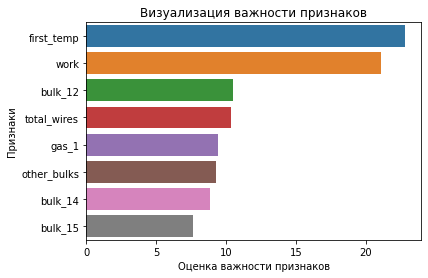

In [62]:
chart_feature_imp(model)

### Выводы

1. Наиболее важным критерием в итоговой модели стала первоначальная температура. Это означает, что решение по оптимизации затрат на энергию может лежать на предыдущем этапе, когда сырье доводят до температуры, соответсвующей первоначальной на данном этапе. 
2. Разброс температрур в большинстве случаев не очень большой, это означает, что можно посмотреть на иные методы оптимизации, например, аналитически поисследовать выбросы тепературы и поискать в них закономерности. 